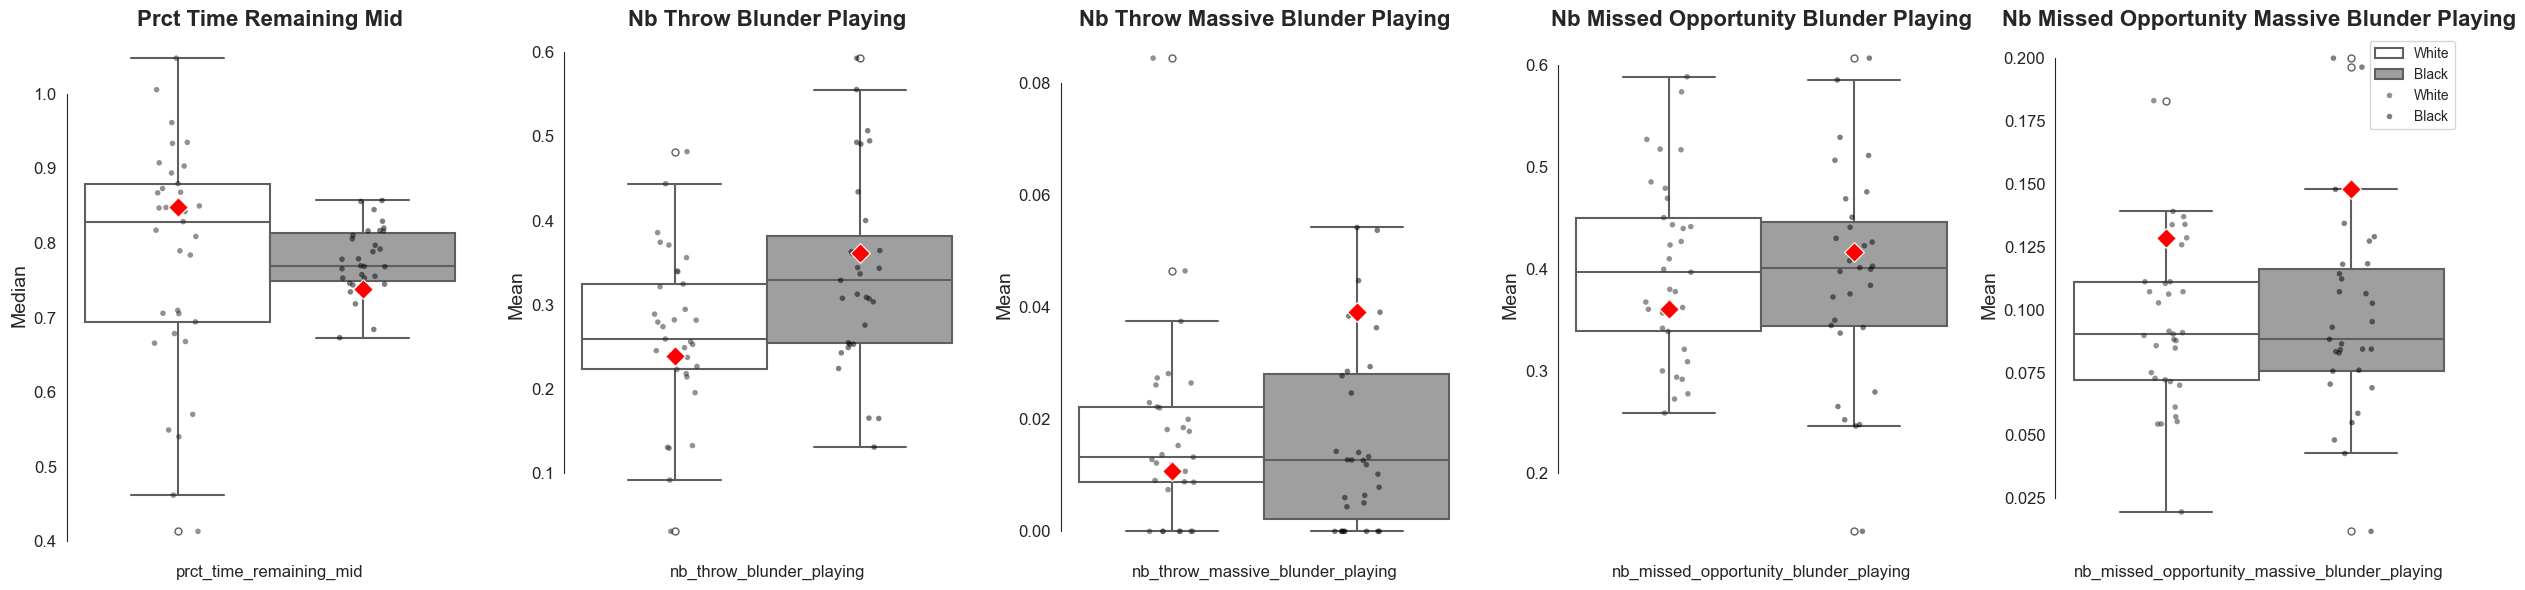

In [3]:
from data.loader import load_query
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict

def aggregate_data(df: pd.DataFrame, agg_config: Dict[str, str], min_games: int = 50) -> pd.DataFrame:
    counts = df.groupby(["username", "playing_as"]).size()
    eligible_users = counts[counts >= min_games].index
    df_filtered = df.set_index(["username", "playing_as"]).loc[eligible_users].reset_index()
    return df_filtered.groupby(["username", "playing_as"]).agg(agg_config).reset_index()

def unpivot_dataset(df: pd.DataFrame) -> pd.DataFrame:
    return df.melt(id_vars=["username", "playing_as"], var_name="metric", value_name="value")

def plot_box_charts_sexy(unpivoted: pd.DataFrame, highlight_username: str, agg_config: Dict[str, str]) -> None:
    # Changed: Removed grid
    sns.set_style("white") 
    metrics = list(agg_config.keys())
    highlight = unpivoted[unpivoted["username"] == highlight_username]

    fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 6), sharey=False)

    playing_as_order = ['White', 'Black']
    palette = {
        "White": "#ffffff", 
        "Black": "#9f9f9f", 
    }

    for i, metric in enumerate(metrics):
        ax = axes[i]
        data = unpivoted[unpivoted["metric"] == metric]

        sns.boxplot(
            data=data,
            x="metric",
            y="value",
            hue="playing_as",
            order=[metric],
            hue_order=playing_as_order,
            palette=palette,
            linewidth=1.5,
            fliersize=5,
            ax=ax
        )

        sns.stripplot(
            data=data,
            x="metric",
            y="value",
            hue="playing_as",
            order=[metric],
            hue_order=playing_as_order,
            dodge=True,
            size=4,
            alpha=0.5,
            ax=ax,
            jitter=True,
            linewidth=0,
            edgecolor=None,
            palette='dark:black'
        )

        # Remove duplicate legends from stripplot
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), title="Playing As")

        sns.despine(ax=ax, trim=True)

        val = highlight[highlight["metric"] == metric]
        if not val.empty:
            for _, row in val.iterrows():
                base_x = 0
                try:
                    hue_idx = playing_as_order.index(row["playing_as"])
                    offset = (-0.2 if hue_idx == 0 else 0.2)
                except ValueError:
                    offset = 0

                sns.scatterplot(
                    x=[base_x + offset],
                    y=[row["value"]],
                    color="red",
                    marker="D",
                    s=100,
                    zorder=10,
                    ax=ax,
                    label=highlight_username if i == 0 else None,
                )

        ax.set_title(metric.replace("_", " ").title(), fontsize=16, fontweight="bold")
        ax.set_xlabel("")
        ax.set_ylabel(agg_config[metric].capitalize(), fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        if i != len(metrics) - 1:
            ax.get_legend().remove()

    plt.tight_layout()
    plt.show()


# --- Run ---
agg_config = {
    "prct_time_remaining_mid"                   : "median",
    "nb_throw_blunder_playing"                  : "mean",
    "nb_throw_massive_blunder_playing"          : "mean",
    "nb_missed_opportunity_blunder_playing"     : "mean",
    "nb_missed_opportunity_massive_blunder_playing" : "mean",
}

df_raw          = load_query("data/agg_games_with_moves__games.sql")
df_agg          = aggregate_data(df_raw, agg_config)
df_unpivoted    = unpivot_dataset(df_agg)

plot_box_charts_sexy(df_unpivoted, highlight_username="Zundorn", agg_config=agg_config)